Model Workflow

# Data Loading &  Processing
## Data source: ccxt for real-time and historical data on OHLCV(open, high, low, closing & volume data) for digital currency (e.g. BTC) using a 1d (daily) timeframe 
Feature Engineering : calculate price, volume & volatility-based indicators 
- Price: Simple Moving Average(SMA), EMA, RSI, MACD (for momentum signals)
--> RSI: measure 
- Volume: OBV (On-Balance Volume), Money Flow Index (MFI)
- Volatility: ATR (Average True Range), Bollinger Bands Width(BBW)



# MODELS:
## 1. XGBoost with feature importances to select <10 features for feature selection 
run 6 xgboost models for close_n_ahead for n = 1 to ... as target variable, to exract predicted values(tnew) as input values for our loss function
- RandomSearch Optimization & 
- BayeasianSearch Optimization 
--> use 3 different optimization techniques: gp_minimize(mathematical), optuna & BayesSearchCV method 

## 2. ARIMA for Time Series - based forecasting
Further Feature engineering: implementing Time Series 
- Add weighted averages based on regression of lagged values, using partial autocorrelation (PACF) to identify autoregressive lags for feature selection
- Implement time-series modelling to forecast short-term price movements using ARIMA, & selecting best ARIMA model based on AIC/BIC criteria to obtain parameters (p - autoregressive order & q - simple moving average order)
Filling missing data with interpolation & normalization


backup model: 
## 3. Linear Regression with PCA for featue selection
- L1 Regularization & 
- L2 Regularization


## Trading Strategy ( based on research paper formula/loss function for calculating weights not provided v hard to obtain weights - suggest a new formula)

Calculate percentage returns and define a treshold to evaluate if price is expected to increase 
--> use log (% return) > x% or <= x% as evaluation criteria (compare against technical indicators?) to buy/sell
--> use own loss function and obtain the best alpha value which returns the best mse (btw tnew and toriginal)
loss function: tnew = w1t1 + w2t2 + ... + w6t6
- WEIGHTS w1, w2,..., w6:
1. Exponential increment
w1 = (1-alpha), w2 = (1-alpha)alpha,..., w6 = (1-alpah)alpha^5
2. Average 
w1 = w2 = ... = w6 = 1/6 alpha



Momentum Oscillators(BUY/SELL SIGNALS)
RSI: 
Purpose: Measures the speed & change of price movements.
Use Case: Buy if RSI < 30 (oversold), Sell if RSI > 70 (overbought)
MACD:
Purpose: Identifies trend reversals via moving average crossovers.
Use Case: Buy if MACD crosses above Signal Line, Sell if MACD crosses below Signal Line
(other indicators we have not considered)
Stochastic Oscillator(STOCH)
Purpose: Identifies overbought & oversold conditions based on recent highs/lows.
Use Case: Buy if %K crosses above %D in oversold zone (<20), Sell if %K crosses below %D in overbought zone (>80)
Rate of Change (ROC)
Purpose: Measures the percentage change of price over a given period.
Use Case: Buy when ROC turns positive, Sell when ROC turns negative.

Volitility Indicators 
Bollinger Bands:
Purpose: Measures price volatility relative to a moving average.
Use Case: Buy when price touches lower band, Sell when price touches upper band.
Average True Range (ATR)
Purpose: Measures market volatility by averaging true range values.
Use Case: High ATR → High volatility, Low ATR → Low volatility.

Volume Indicators 
On-Balance Volume (OBV)
Purpose: Cumulative volume indicator that tracks buying/selling pressure.
Use Case: Rising OBV suggests buying pressure, declining OBV suggests selling pressure.
Money Flow Index (MFI)
Purpose: Volume-weighted RSI to assess buying/selling pressure.
Use Case: Buy if MFI < 20, Sell if MFI > 80


In [105]:
#Data Loading
import ccxt
import pandas as pd
import time
from datetime import datetime, timedelta

# Initialize exchange
exchange = ccxt.binance()

# Define symbol and timeframe
symbol = 'BTC/USDT'
timeframe = '1d'

# Calculate timestamp for 1 year ago from Janauary as train data 
end_date = datetime(2025, 1, 1) 
start_date = end_date - timedelta(days=366)  

# Convert to milliseconds (Binance API uses Unix timestamp in milliseconds)
since = int(start_date.timestamp() * 1000)

# Fetch historical OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)

# Convert to DataFrame
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

# Display the first few rows
print(data.head())
print(data.tail())  # Check the latest date to ensure correct range


   timestamp      open      high       low     close       volume
0 2024-01-01  42283.58  44184.10  42180.77  44179.55  27174.29903
1 2024-01-02  44179.55  45879.63  44148.34  44946.91  65146.40661
2 2024-01-03  44946.91  45500.00  40750.00  42845.23  81194.55173
3 2024-01-04  42845.23  44729.58  42613.77  44151.10  48038.06334
4 2024-01-05  44151.10  44357.46  42450.00  44145.11  48075.25327
     timestamp      open      high       low     close       volume
441 2025-03-17  82574.52  84756.83  82456.00  84010.03  17214.74358
442 2025-03-18  84010.02  84021.74  81134.66  82715.03  17610.89883
443 2025-03-19  82715.03  87000.00  82547.16  86845.94  28151.05374
444 2025-03-20  86845.93  87453.67  83655.23  84223.39  22090.30463
445 2025-03-21  84223.38  84850.33  84180.09  84662.75   1738.55899


In [ ]:
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice, money_flow_index
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Calculate technical indicators
def calculate_technical_indicators(data):
    data['SMA_5'] = SMAIndicator(data['close'], window=5).sma_indicator()
    data['SMA_10'] = SMAIndicator(data['close'], window=10).sma_indicator()
    data['SMA_15'] = SMAIndicator(data['close'], window=15).sma_indicator()
    data['SMA_30'] = SMAIndicator(data['close'], window=30).sma_indicator()
    data['EMA_9'] = EMAIndicator(data['close'], window=9).ema_indicator()
    data['RSI'] = RSIIndicator(data['close'], window=14).rsi()
    macd = MACD(data['close'], window_fast=12, window_slow=26, window_sign=9)
    data['MACD'] = macd.macd() 
    data['MACD_signal'] = macd.macd_signal()
    data['MACD_hist'] = macd.macd_diff()
    data['OBV'] = OnBalanceVolumeIndicator(data['close'], data['volume']).on_balance_volume()
    data['MFI_10'] = money_flow_index(data['high'], data['low'], data['close'], data['volume'], window=10)
    # data['ATR'] = AverageTrueRange(data['high'], data['low'], data['close'], window=14).average_true_range()
    # bands = BollingerBands(data['close'], window=20, window_dev = 2)
    # data['upper_band'] = bands.bollinger_hband()
    # data['middle_band'] = bands.bollinger_mavg()
    # data['lower_band'] = bands.bollinger_lband() 
    # data['BBW'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    # Lagged Close prices
    data['close_lag_1'] = data['close'].shift(1)
    data['close_lag_2'] = data['close'].shift(2)
    #lead close prices
    for n in [1, 2, 5, 10, 20, 30]:
        data[f'close_{n}_ahead'] = data['close'].shift(-n)
    data['log_return'] = np.log(data['close']).diff()
    data['return_1'] =  (data['close_1_ahead'] - data['close']) / data['close']  
    
    return data 

#handle missing values
def handle_missing_data(data):
    data.ffill(inplace=True)
    data.bfill(inplace = True)
    return data 

# Normalization
def normalize_data(df):
    scaler = StandardScaler()
    df[['SMA', 'EMA', 'MACD', 'OBV', 'ATR']] = scaler.fit_transform(df[['SMA', 'EMA', 'MACD', 'OBV', 'ATR']])
    return df

btc_data = calculate_technical_indicators(data)
btc_data = handle_missing_data(btc_data)
# btc_data = normalize_data(btc_data)

#inspect data
print(btc_data.head()) 
print(btc_data.tail())


   timestamp      open      high       low     close       volume     SMA_5  \
0 2024-01-01  42283.58  44184.10  42180.77  44179.55  27174.29903  44053.58   
1 2024-01-02  44179.55  45879.63  44148.34  44946.91  65146.40661  44053.58   
2 2024-01-03  44946.91  45500.00  40750.00  42845.23  81194.55173  44053.58   
3 2024-01-04  42845.23  44729.58  42613.77  44151.10  48038.06334  44053.58   
4 2024-01-05  44151.10  44357.46  42450.00  44145.11  48075.25327  44053.58   

      SMA_10        SMA_15        SMA_30  ...  close_2_ahead  close_5_ahead  \
0  44788.027  44272.906667  42933.371333  ...       42845.23       43968.32   
1  44788.027  44272.906667  42933.371333  ...       44151.10       43929.02   
2  44788.027  44272.906667  42933.371333  ...       44145.11       46951.04   
3  44788.027  44272.906667  42933.371333  ...       43968.32       46110.00   
4  44788.027  44272.906667  42933.371333  ...       43929.02       46653.99   

   close_10_ahead  close_20_ahead  close_30_ahead 

In [ ]:
print(btc_data.columns)
print(btc_data.summary())
# check if there are any missing values
print(btc_data.isnull().sum())

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'SMA_30', 'EMA_9', 'RSI', 'MACD', 'MACD_signal',
       'MACD_hist', 'close_lag_1', 'close_lag_2', 'close_1_ahead',
       'close_2_ahead', 'close_5_ahead', 'close_10_ahead', 'close_20_ahead',
       'close_30_ahead', 'log_return', 'return_1', 'OBV', 'MFI_10', 'ATR'],
      dtype='object')
timestamp         0
open              0
high              0
low               0
close             0
volume            0
SMA_5             0
SMA_10            0
SMA_15            0
SMA_30            0
EMA_9             0
RSI               0
MACD              0
MACD_signal       0
MACD_hist         0
close_lag_1       0
close_lag_2       0
close_1_ahead     0
close_2_ahead     0
close_5_ahead     0
close_10_ahead    0
close_20_ahead    0
close_30_ahead    0
log_return        0
return_1          0
OBV               0
MFI_10            0
ATR               0
dtype: int64


In [ ]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt 

#Distribution of Each Indicaor 
indicators = ['SMA', 'EMA', 'RSI', 'MACD']  # Select key indicators
def plot_eda():
    plt.figure(figsize=(12, 6))
    for i, indicator in enumerate(indicators):
        plt.subplot(2, 4, i + 1)
        sns.histplot(data[indicator], kde=True, bins=30)
        plt.title(indicator)
    plt.tight_layout()
    plt.show()

    #Check for Correlations(Feature Redundancy)
    #Some indicators might be highly correlated, making them redundant
    #If correlation > 0.85, remove one of the correlated features.
    # Example: SMA and EMA are usually correlated → Keep only one.
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Technical Indicators")
    plt.show()

    #Comparing Indicators with closing prices (Plot Trends Over Time)
    # Check how SMA and EMA interact with price.
    # Identify points where indicators signal trend reversals.

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['close'], label='Close Price', color='black')
    plt.plot(data.index, data['SMA'], label='SMA', linestyle='dashed', color='blue')
    plt.plot(data.index, data['EMA'], label='EMA', linestyle='dashed', color='red')
    plt.legend()
    plt.title("Price with SMA and EMA")
    plt.show()

    #Identify Overbought & Oversold Conditions (RSI & MACS)
    # A. RSI (Relative Strength Index)
    # RSI > 70 → Overbought (possible sell signal)
    # RSI < 30 → Oversold (possible buy signal)
    # Are most RSI values in a normal range (30-70)?
    # Do RSI peaks align with price reversals?
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['RSI'], label="RSI", color="purple")
    plt.axhline(70, linestyle="dashed", color="red", label="Overbought")
    plt.axhline(30, linestyle="dashed", color="green", label="Oversold")
    plt.legend()
    plt.title("RSI Indicator")
    plt.show()

    # B. MACD (Moving Average Convergence Divergence)
    # MACD > Signal Line → Bullish
    # MACD < Signal Line → Bearish
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['MACD'], label='MACD', color='blue')
    plt.plot(data.index, data['MACD_signal'], label='Signal Line', color='red')
    plt.axhline(0, linestyle="dashed", color="black")
    plt.legend()
    plt.title("MACD Indicator")
    plt.show()

    #Aurocorrelation & Seasonality
    #Check if past price values influence future prices using Partial Autocorrelation (PACF).
    from statsmodels.graphics.tsaplots import plot_pacf
    plot_pacf(data['close'], lags=20)
    plt.title("Partial Autocorrelation of Closing Price")
    plt.show()


# XGBoost

In [164]:
print(btc_data.columns)

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'SMA_30', 'EMA_9', 'RSI', 'MACD', 'MACD_signal',
       'MACD_hist', 'close_lag_1', 'close_lag_2', 'close_1_ahead',
       'close_2_ahead', 'close_5_ahead', 'close_10_ahead', 'close_20_ahead',
       'close_30_ahead', 'log_return', 'return_1', 'OBV', 'MFI_10', 'ATR'],
      dtype='object')


In [ ]:
data = btc_data
# Features and target
features = ['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'EMA_9', 'MACD', 'MACD_signal', 'OBV', 'MFI_10', 'RSI', 'ATR' , 'close_lag_1', 'close_lag_2']
targets = ['close_1_ahead', 'close_2_ahead', 'close_5_ahead', 'close_10_ahead', 'close_20_ahead', 'close_30_ahead', 'return_1']

#define date range correctly
train_end_date = pd.to_datetime('2025-01-01') 
test_end_date = pd.to_datetime('2025-03-01')

# Split the data
train_data = data[data['timestamp'] < train_end_date]
test_data = data[(data['timestamp'] >= train_end_date) & (data['timestamp'] < test_end_date)]


# Split into X & y 
X_train = train_data[features]
X_test = test_data[features]


y_train = train_data[targets]
y_test = test_data[targets]


print(f"Train data: {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
print(f"Test data: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")

Train data: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Test data: 2025-01-01 00:00:00 to 2025-02-28 00:00:00


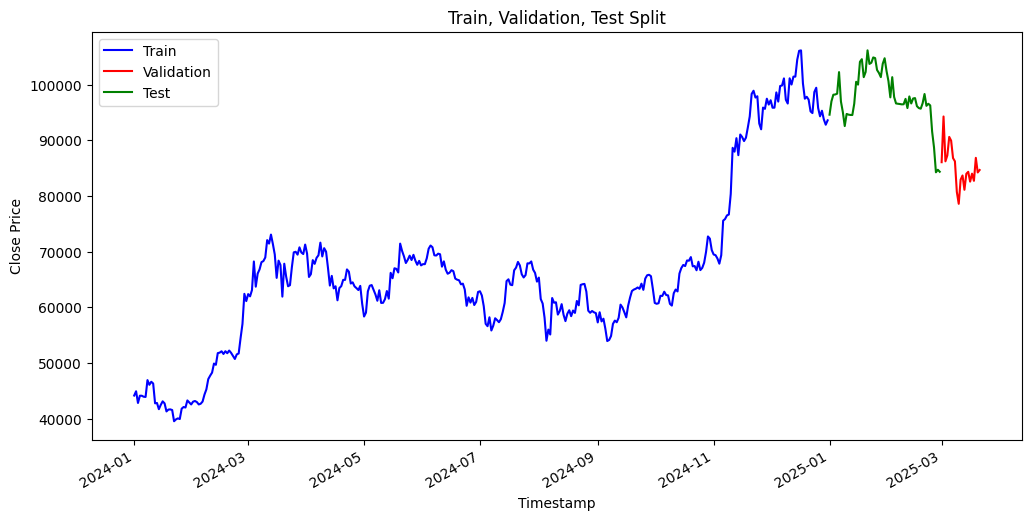

In [167]:
def visualize_train_test_split():
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['timestamp'], train_data['close'], label='Train', color='blue')
    plt.plot(val_data['timestamp'], val_data['close'], label='Validation', color='red')
    plt.plot(test_data['timestamp'], test_data['close'], label='Test', color='green')
    plt.legend()
    plt.title("Train, Validation, Test Split")
    plt.xlabel('Timestamp')
    plt.ylabel('Close Price')
    plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
    plt.show()
visualize_train_test_split()

In [35]:
# Plot BTC price development candlestick chart
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=data['timestamp'], open=data['open'], high=data['high'], low=data['low'], close=data['close'])])
fig.update_layout(title='BTC/USDT Price Development', xaxis_title='Date', yaxis_title='Price')
#theme minimal
fig.update_layout(template='simple_white')
fig.show()


### Hyperparameter Tuning

In [ ]:
#all libraries
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV, gp_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.space import Real, Integer
import numpy as np
import matplotlib.pyplot as plt
import optuna

Grid Search CV

In [ ]:
def grid_search_cv():# Define the model
    model = XGBRegressor()

    # Define hyperparameters
    param_grid = {
        'max_depth': [5, 6, 7, 8, 9, 11, 13, 14],
        'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.2, 0.4, 0.7],
        'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6],
        'reg_alpha': [0.4, 0.8, 1.6, 6.4],
        'reg_lambda': [0.4, 0.8, 1.6, 6.4]
    }

    # Perform grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(train_data[features], train_data[targets[0]])

Random Search CV

===== XGBoost Metric Evaluation ===== 
Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Validation Mean Squared Error (MSE): 11986406.7950
Validation Mean Absolute Error (MAE): 2841.4250
Validation R-squared (R²): 0.5208
[0.27351615 0.15399756 0.12707506 0.19073728 0.00093237 0.00595459
 0.19111289 0.0193832  0.01463612 0.00162029 0.00104593 0.00239108
 0.00110212 0.00077787 0.00175659 0.00106507 0.01023228 0.0026635 ]
XGBoost Feature Importances:
 open           0.273516
SMA_10         0.191113
close          0.190737
high           0.153998
low            0.127075
SMA_15         0.019383
SMA_30         0.014636
close_lag_1    0.010232
SMA_5          0.005955
close_lag_2    0.002663
MACD_signal    0.002391
RSI            0.001757
EMA_9          0.001620
OBV            0.001102
ATR            0.001065
MACD           0.001046
volume       

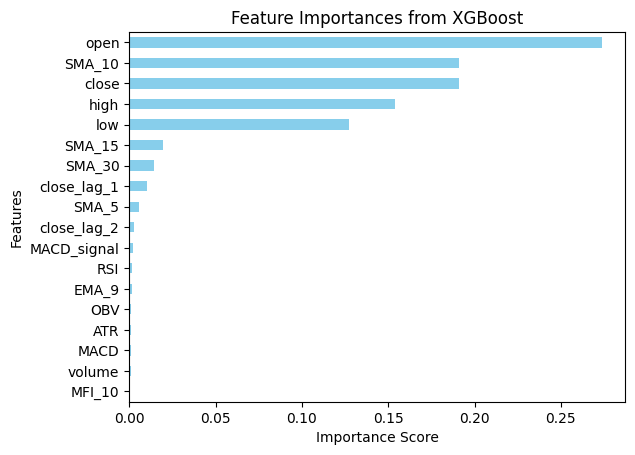

Selected Features: Index(['open', 'SMA_10', 'close', 'high', 'low', 'SMA_15', 'SMA_30',
       'close_lag_1', 'SMA_5', 'close_lag_2'],
      dtype='object')
Train MSE: 1527198.9621
Train MAE: 897.5374
Train R-squared (R²): 0.9929
Test MSE: 8667051.4525
Test MAE: 2336.9743
Test R-squared (R²): 0.6535


In [219]:
# random search for best hyperparameters for XGBoost
def random_search():
    #define time-series cross validation
    tscv = TimeSeriesSplit(n_splits=10)

    # Define the model
    model = XGBRegressor(random_state = 42)

    param_grid = {
        'n_estimators': [50, 100, 200],  
        'learning_rate': [0.01, 0.05],  
        'max_depth': [3, 5],  
        'min_child_weight': [5, 10],  
        'subsample': [0.6, 0.8, 1.0],  
        'colsample_bytree': [0.6, 0.8, 1.0],  
        'gamma': [0, 0.1, 0.2],  
        'reg_alpha': [0.1, 1.0],  
        'reg_lambda': [1.0, 2.0],  
    }

    # Perform random search
    random_search = RandomizedSearchCV(
        model, 
        param_grid, 
        n_iter=100, 
        cv=tscv, 
        n_jobs=-1,
        random_state=42,
        scoring='neg_mean_squared_error'
    )
    random_search.fit(X_train, y_train['close_1_ahead'])

    # Output the best hyperparameters
    best_params = random_search.best_params_
    print(f"===== XGBoost Metric Evaluation ===== ")
    print(f"Best Hyperparameters:", best_params)

    #Evaluate best model on validation set
    best_model = random_search.best_estimator_
    y_test_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test['close_1_ahead'], y_test_pred)
    mae = mean_absolute_error(y_test['close_1_ahead'], y_test_pred)
    r2 = r2_score(y_test['close_1_ahead'], y_test_pred)

    print(f"Validation Mean Squared Error (MSE): {mse:.4f}")
    print(f"Validation Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Validation R-squared (R²): {r2:.4f}")

    # Feature importance
    feature_importances = best_model.feature_importances_

    print(feature_importances)

    # Get feature importances as a Pandas Series
    feature_importances_xgb_rs = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("XGBoost Feature Importances:\n", feature_importances_xgb_rs)

    # Plot importance
    feature_importances_xgb_rs.sort_values(ascending=True).plot(kind='barh', color='skyblue')
    plt.title("Feature Importances from XGBoost")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()

    # Select important features (threshold > 0.05)
    selected_features_xgb_rs = feature_importances_xgb_rs.nlargest(10).index
    print("Selected Features:", selected_features_xgb_rs)

    # **Train XGBRegressor using only the selected features**
    X_train_selected = X_train[selected_features_xgb_rs]
    X_test_selected = X_test[selected_features_xgb_rs]

    # best_params = {
    #     'subsample': 0.8, 
    #     'reg_lambda': 1.0, 
    #     'reg_alpha': 1.0, 
    #     'n_estimators': 200, 
    #     'min_child_weight': 5, 
    #     'max_depth': 3, 
    #     'learning_rate': 0.05, 
    #     'gamma': 0, 
    #     'colsample_bytree': 0.6
    #     }

    xgb_rs = XGBRegressor(
        **best_params, 
        eval_metric='rmse', 
        #early_stopping_rounds=10
    )

    #eval_set = [(X_val_selected, y_test['close_1_ahead'])]
    
    # Train on selected features
    xgb_rs.fit(X_train_selected, y_train['close_1_ahead'], verbose=True)

    # Predict on train data
    train_predictions_rs = xgb_rs.predict(X_train_selected)
    train_mse = mean_squared_error(y_train['close_1_ahead'], train_predictions_rs)
    train_mae = mean_absolute_error(y_train['close_1_ahead'], train_predictions_rs)
    train_r2 = r2_score(y_train['close_1_ahead'], train_predictions_rs)
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Train R-squared (R²): {train_r2:.4f}")

    # Predict on test data
    test_predictions_rs = xgb_rs.predict(X_test_selected)
    test_mse = mean_squared_error(y_test['close_1_ahead'], test_predictions_rs)
    test_mae = mean_absolute_error(y_test['close_1_ahead'], test_predictions_rs)
    test_r2 = r2_score(y_test['close_1_ahead'], test_predictions_rs)
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test R-squared (R²): {test_r2:.4f}")


    return train_predictions_rs, test_predictions_rs

train_predictions_rs, test_predictions_rs = random_search()

In [209]:
def line_plot(train_pred, test_pred, target_var):
    #Visualizing random search results
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['timestamp'], y_train[target_var], label='Actual Prices', color='blue')
    plt.plot(train_data['timestamp'], train_pred, label='Predicted Prices', color='red', linestyle='--')
    plt.title("Actual vs Predicted Prices (Train Set)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # Plot for test set
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['timestamp'], y_test[target_var], label='Actual Prices', color='blue')
    plt.plot(test_data['timestamp'], test_pred, label='Predicted Prices', color='green', linestyle='--')
    plt.title("Actual vs Predicted Prices (Test Set)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
#line_plot()


def residual_plot(val_pred, test_pred):
    val_residuals = y_train[targets[0]] - val_pred
    test_residuals = test_data[targets[0]] - test_pred
    # Plot residuals for validation set
    plt.figure(figsize=(12, 6))
    plt.scatter(val_pred, val_residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot (Validation Set)")
    plt.xlabel("Predicted Prices")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()

    # Plot residuals for test set
    plt.figure(figsize=(12, 6))
    plt.scatter(test_pred, test_residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot (Test Set)")
    plt.xlabel("Predicted Prices")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()
#residual_plot()

# def mse_plot(train_mse, test_mse)
    


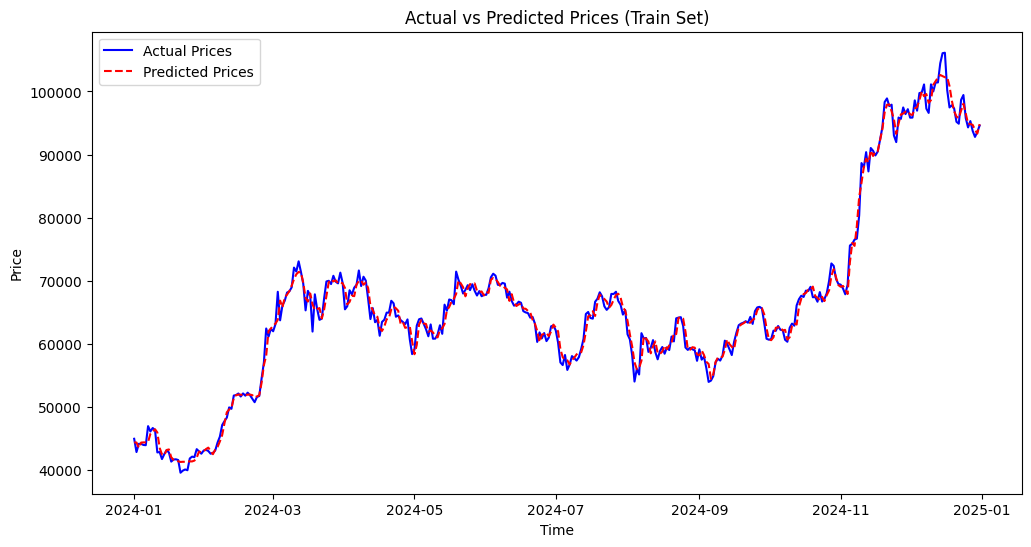

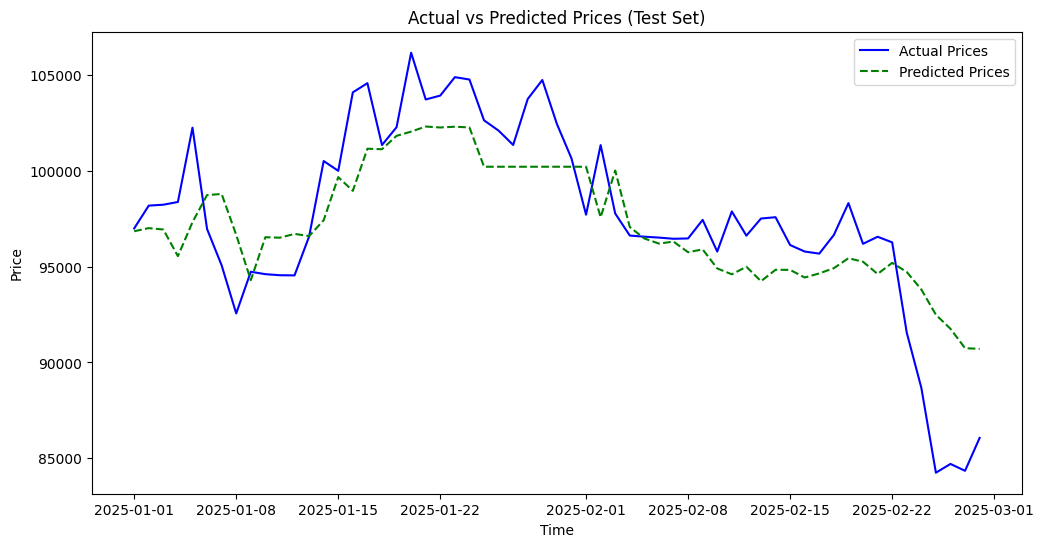

In [220]:
line_plot(train_predictions_rs, test_predictions_rs, 'close_1_ahead')

Bayesian Optimization

In [ ]:
def bayes_xg_boost(target_var):
    # Define the model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=50, random_state=42)

    tscv = TimeSeriesSplit(n_splits = 5)

    # Define the search space for hyperparameters (in a list for gp_minimize)
    search_space = [
        Real(0.01, 0.7, name='learning_rate', prior='log-uniform'),
        Integer(5, 14, name='max_depth'),
        Real(0, 1.6, name='gamma'),
        Real(0.4, 6.4, name='alpha'),
        Real(0.4, 6.4, name='lambda_'),
        Integer(50,200, name='n_estimators')
    ]

    # Convert search_space to a dictionary for BayesSearchCV
    search_space_dict = {
        'learning_rate': Real(0.01, 0.7, prior='log-uniform'),
        'max_depth': Integer(5, 14),
        'gamma': Real(0, 1.6),
        'reg_alpha': Real(0.4, 6.4),
        'reg_lambda': Real(0.4, 6.4), 
        'n_estimarots': Integer(50,200)
    }

    # Define the objective function for gp_minimize
    @use_named_args(search_space)
    def objective(learning_rate, max_depth, gamma, alpha, lambda_, n_estimators):
        # Set the model parameters
        model.set_params(
            learning_rate=learning_rate,
            max_depth=max_depth,
            gamma=gamma,
            alpha=alpha,
            lambda_=lambda_, 
            n_estimators = n_estimators
        )
        scores = cross_val_score(model, X_train, train_data[target_var], 
                                cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
        
        return -np.mean(scores) 

    # Step 1: Optimize the mathematical function using gp_minimize
    result = gp_minimize(
        func=objective,
        dimensions=search_space,
        n_calls=30,
        n_initial_points=10,
        acq_func="EI",
        random_state=42
    )

    # Best parameters from gp_minimize
    best_params_gp = {
        'learning_rate': result.x[0],
        'max_depth': int(result.x[1]),
        'gamma': result.x[2],
        'alpha': result.x[3],
        'lambda': result.x[4]

    }

    # Plot convergence of gp_minimize
    from skopt.plots import plot_convergence
    plot_convergence(result)
    plt.title("Convergence of gp_minimize")
    plt.show()

    #evaluate gp_minimize parameters
    model_gp = XGBRegressor(**best_params_gp, objective='reg:squarederror', random_state=42)
    model_gp.fit(X_train, y_train[target_var])
    test_prediction_gp = model_gp.predict(X_test)
    mse_gp = mean_squared_error(y_test[target_var], test_prediction_gp)
    print(f"Prediction MSE (gp_minimize): {mse_gp}")


    # Step 2: Optimize hyperparameters using BayesSearchCV
    opt = BayesSearchCV(
        model,
        search_space_dict,
        cv=tscv,
        n_jobs=-1,
        scoring='neg_mean_squared_error',
        random_state=42
    )

    opt.fit(X_train, y_train[target_var])

    # Best parameters from BayesSearchCV
    best_params_bayescv = opt.best_params_
    test_prediction_bayescv = opt.predict(X_test)
    mse_bayescv = mean_squared_error(y_test[target_var], test_prediction_bayescv)
    print(f"Prediction MSE (BayesSearchCV): {mse_bayescv}")

    def objective_optuna(trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 5, 7),
            'gamma': trial.suggest_float('gamma', 0, 1.6),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.4, 6.4),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.4, 6.4), 
            'n_estimators': trial.suggest_int('n_estimators', 50, 200)
        }
        model = XGBRegressor(**params, objective='reg:squarederror', random_state=42)
        scores = cross_val_score(model, X_train, y_train[target_var], 
                                cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        return -np.mean(scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective_optuna, n_trials=50)

    best_params_optuna = study.best_params
    model_optuna = XGBRegressor(**best_params_optuna, objective='reg:squarederror', random_state=42)
    model_optuna.fit(X_train, y_train[target_var])
    test_prediction_optuna = model_optuna.predict(X_test)
    mse_optuna = mean_squared_error(y_test[target_var], test_prediction_optuna)
    print(f"Prediction MSE (Optuna): {mse_optuna}")

    # Step 4: Compare results and select the best parameters
    results = {
        'gp_minimize': {'params': best_params_gp, 'mse': mse_gp},
        'BayesSearchCV': {'params': best_params_bayescv, 'mse': mse_bayescv},
        'Optuna': {'params': best_params_optuna, 'mse': mse_optuna}
    }

    best_method = min(results, key=lambda k: results[k]['mse'])
    best_params_final = results[best_method]['params']
    print(f"Best method: {best_method}")
    print(f"Best parameters: {best_params_final}")

    # Step 5: Train the final model with the best parameters
    final_model = XGBRegressor(**best_params_final, objective='reg:squarederror', random_state=42)
    final_model.fit(X_train, y_train[target_var])


    #Compare model with train set
    train_prediction_bayes = final_model.predict(X_train)
    train_mse = mean_squared_error(y_train[target_var], train_prediction_bayes)
    print(f"Train MSE: {train_mse}")

    # Evaluate the final model on the test set
    test_prediction_bayes = final_model.predict(X_test)
    test_mse = mean_squared_error(y_test[target_var], test_prediction_bayes)
    print(f"Test MSE (Final Model): {test_mse}")

    return  final_model, best_params_final, train_prediction_bayes, test_prediction_bayes 

C:\Users\alyss\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [0.7, np.int64(5), 0.0, 6.4, 6.4, np.int64(200)] before, using random point [0.03662859382072234, np.int64(11), 1.1660925714364345, 3.854721543696248, 0.9872065868539645, np.int64(61)]

C:\Users\alyss\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [0.7, np.int64(5), 0.0, 6.4, 0.4, np.int64(200)] before, using random point [0.0376892334991298, np.int64(12), 0.13152559979856718, 1.3381061250284705, 5.233300050223079, np.int64(71)]



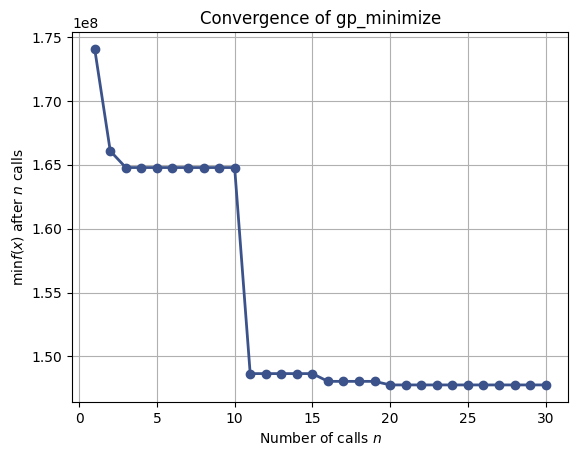

Validation MSE (gp_minimize): 20205393.688406337


[I 2025-03-25 20:06:42,297] A new study created in memory with name: no-name-b3250107-cd89-4bd1-9a36-11460745cf89


Validation MSE (BayesSearchCV): 13659404.700359339


[I 2025-03-25 20:06:42,677] Trial 0 finished with value: 181749942.80991822 and parameters: {'learning_rate': 0.06514897748803357, 'max_depth': 5, 'gamma': 0.5313307113311414, 'reg_alpha': 0.5605823534873419, 'reg_lambda': 5.812760721000101, 'n_estimators': 115}. Best is trial 0 with value: 181749942.80991822.
[I 2025-03-25 20:06:44,663] Trial 1 finished with value: 175819248.42695802 and parameters: {'learning_rate': 0.07298336806551887, 'max_depth': 7, 'gamma': 0.43456886494948005, 'reg_alpha': 2.472358038567151, 'reg_lambda': 1.4856888947484221, 'n_estimators': 200}. Best is trial 1 with value: 175819248.42695802.
[I 2025-03-25 20:06:45,211] Trial 2 finished with value: 179735848.78883103 and parameters: {'learning_rate': 0.09048495816473373, 'max_depth': 6, 'gamma': 1.5345858330112074, 'reg_alpha': 4.8547597672876455, 'reg_lambda': 2.409043462032997, 'n_estimators': 71}. Best is trial 1 with value: 175819248.42695802.
[I 2025-03-25 20:06:46,089] Trial 3 finished with value: 1838267

Prediction MSE (Optuna): 7063959.831411664
Best method: Optuna
Best parameters: {'learning_rate': 0.06407506757323533, 'max_depth': 7, 'gamma': 0.3176027205238525, 'reg_alpha': 2.298976852330834, 'reg_lambda': 0.41689240648319925, 'n_estimators': 87}
Train MSE: 60823.05652082104
Test MSE (Final Model): 7063959.831411664


In [214]:
bayes_xg_boost_1_model, bayes_xg_boost_1_params, train_prediction_bayes, test_prediction_bayes = bayes_xg_boost('close_1_ahead')

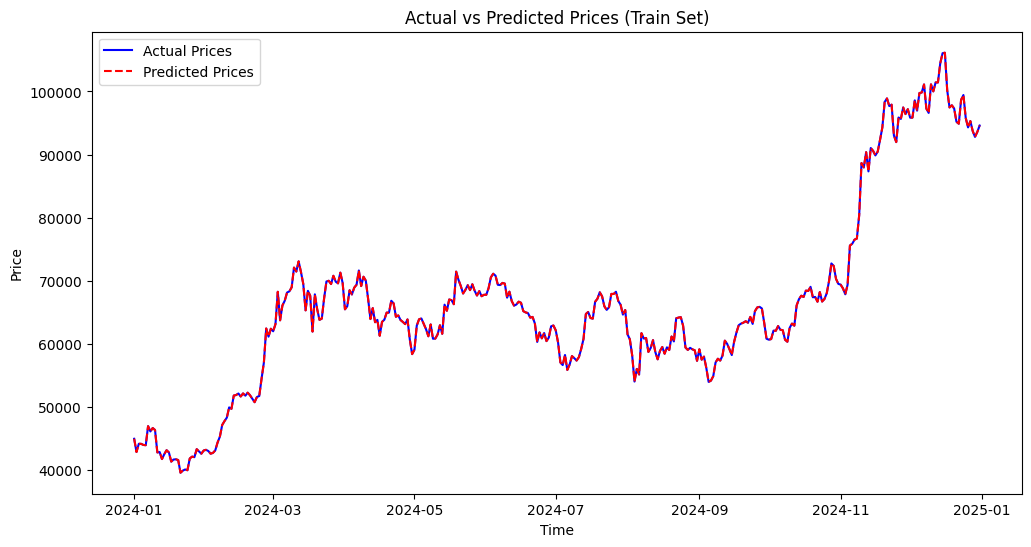

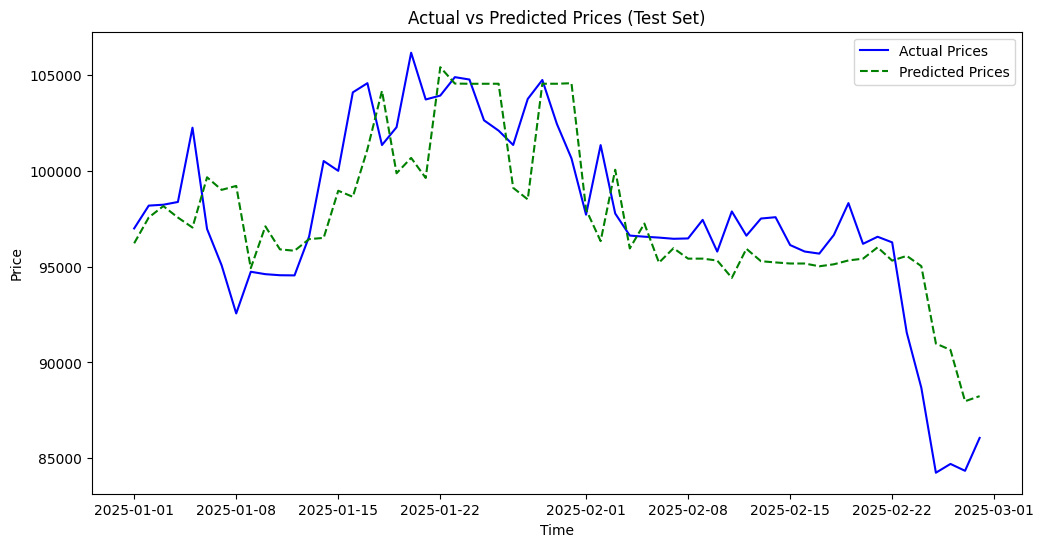

In [211]:
line_plot(train_prediction_bayes, test_prediction_bayes, 'close_1_ahead')

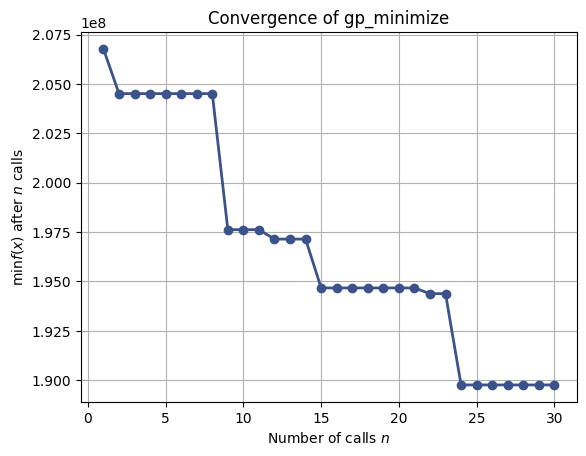

Validation MSE (gp_minimize): 17462227.93993555


C:\Users\alyss\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [0.0, 0.7, np.int64(12), np.int64(50), 0.4, 0.4] before, using random point [0.4582834703303223, 0.5515451397700687, np.int64(7), np.int64(112), 2.5435738487727098, 4.483875627261293]

C:\Users\alyss\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [0.0, 0.7, np.int64(12), np.int64(50), 6.4, 0.4] before, using random point [1.0648872406697254, 0.33822478478657075, np.int64(12), np.int64(190), 3.994643136600565, 5.153587345902463]

[I 2025-03-25 19:57:26,119] A new study created in memory with name: no-name-62e97e18-9f94-4c6e-bda4-6905b902d59f


Validation MSE (BayesSearchCV): 14810678.09939832


[I 2025-03-25 19:57:26,900] Trial 0 finished with value: 194330758.80193105 and parameters: {'learning_rate': 0.04394227131847601, 'max_depth': 5, 'gamma': 1.3885611254870813, 'reg_alpha': 4.140581956946308, 'reg_lambda': 0.4462956877260177, 'n_estimators': 92}. Best is trial 0 with value: 194330758.80193105.
[I 2025-03-25 19:57:31,070] Trial 1 finished with value: 222387930.82510266 and parameters: {'learning_rate': 0.17771152590678094, 'max_depth': 12, 'gamma': 1.1972120225783962, 'reg_alpha': 1.611724526958111, 'reg_lambda': 4.271863411019999, 'n_estimators': 117}. Best is trial 0 with value: 194330758.80193105.
[I 2025-03-25 19:57:34,827] Trial 2 finished with value: 187208381.43500203 and parameters: {'learning_rate': 0.06614211309489865, 'max_depth': 11, 'gamma': 0.9934319108811366, 'reg_alpha': 4.717141777447234, 'reg_lambda': 0.4888902595156618, 'n_estimators': 124}. Best is trial 2 with value: 187208381.43500203.
[I 2025-03-25 19:57:35,659] Trial 3 finished with value: 2140264

Prediction MSE (Optuna): 16228556.440252481
Best method: BayesSearchCV
Best parameters: OrderedDict([('gamma', 0.0), ('learning_rate', 0.12081476020159243), ('max_depth', 13), ('n_estimarots', 50), ('reg_alpha', 6.4), ('reg_lambda', 0.4)])
Train MSE: 2.6987187392609564
Test MSE (Final Model): 14842914.936158905


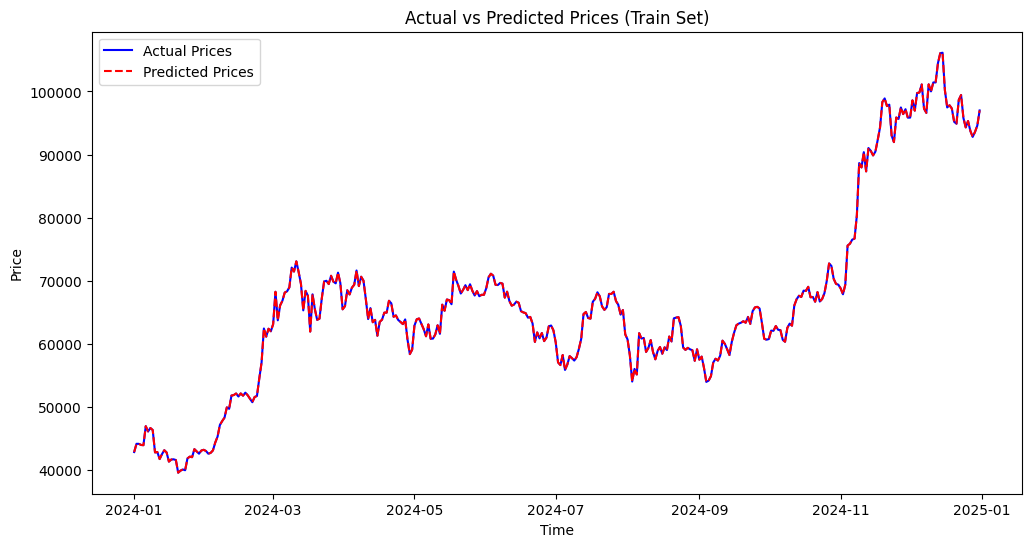

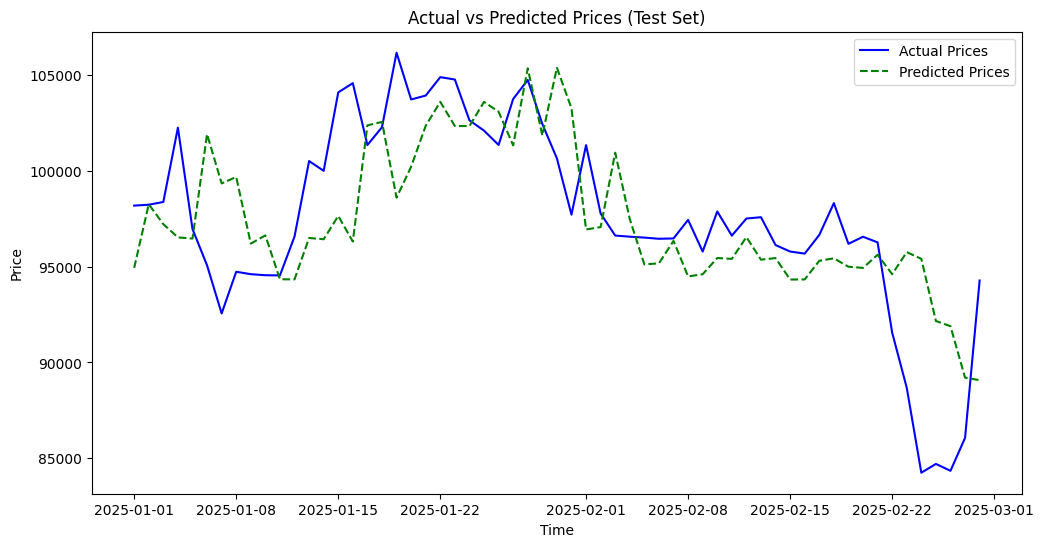

In [212]:
bayes_xg_boost_2_model, bayes_xg_boost_2_params, train_prediction_bayes, test_prediction_bayes = bayes_xg_boost('close_2_ahead')
line_plot(train_prediction_bayes, test_prediction_bayes, 'close_2_ahead')


C:\Users\alyss\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [0.7, np.int64(5), 0.0, 6.4, 0.4, np.int64(50)] before, using random point [0.1673288012808043, np.int64(8), 1.2544063359741036, 2.3213554569197634, 5.493037376816062, np.int64(171)]



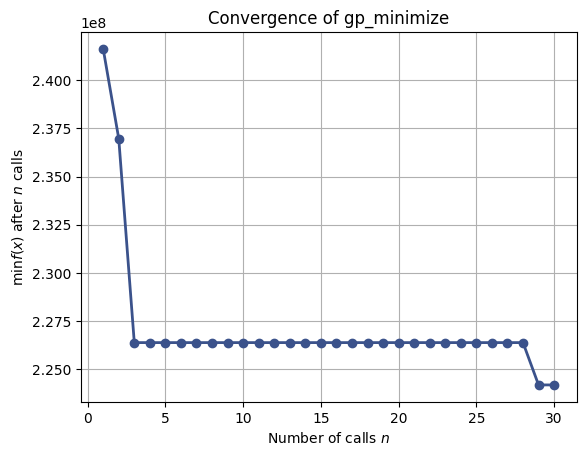

Validation MSE (gp_minimize): 39039100.34217382


[I 2025-03-25 20:34:06,683] A new study created in memory with name: no-name-28e0280a-7f2e-44a7-a041-704482003fcf


Validation MSE (BayesSearchCV): 35984082.02451831


[I 2025-03-25 20:34:07,619] Trial 0 finished with value: 247329270.3587544 and parameters: {'learning_rate': 0.05382907306968771, 'max_depth': 7, 'gamma': 0.10269395053214776, 'reg_alpha': 3.9758918753612966, 'reg_lambda': 2.5945738071351516, 'n_estimators': 93}. Best is trial 0 with value: 247329270.3587544.
[I 2025-03-25 20:34:08,232] Trial 1 finished with value: 235784264.85730258 and parameters: {'learning_rate': 0.09211846393448467, 'max_depth': 5, 'gamma': 0.10597585409634398, 'reg_alpha': 5.598823132656056, 'reg_lambda': 1.2291787491102468, 'n_estimators': 118}. Best is trial 1 with value: 235784264.85730258.
[I 2025-03-25 20:34:10,078] Trial 2 finished with value: 254988956.81702536 and parameters: {'learning_rate': 0.08539312694889184, 'max_depth': 7, 'gamma': 1.3503412487575979, 'reg_alpha': 4.677976206784031, 'reg_lambda': 5.602381553042098, 'n_estimators': 151}. Best is trial 1 with value: 235784264.85730258.
[I 2025-03-25 20:34:11,474] Trial 3 finished with value: 24696771

Prediction MSE (Optuna): 30395977.26681141
Best method: Optuna
Best parameters: {'learning_rate': 0.051384651290295555, 'max_depth': 5, 'gamma': 1.476147758657865, 'reg_alpha': 3.524540445955382, 'reg_lambda': 0.9868924523837499, 'n_estimators': 123}
Train MSE: 448541.5985346796
Test MSE (Final Model): 30395977.26681141


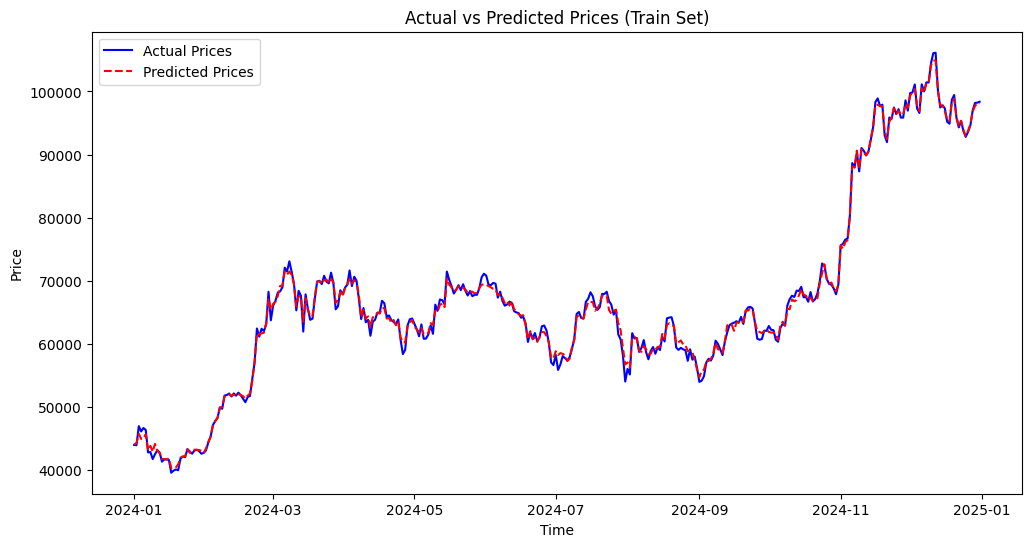

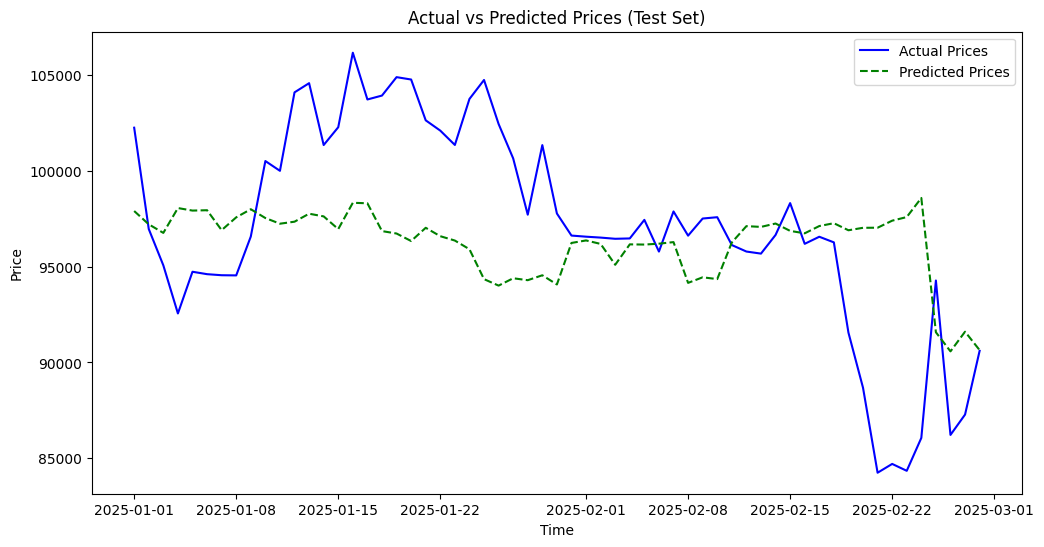

In [216]:
bayes_xg_boost_5_model, bayes_xg_boost_5_params, train_prediction_bayes, test_prediction_bayes = bayes_xg_boost('close_5_ahead')
line_plot(train_prediction_bayes, test_prediction_bayes, 'close_5_ahead')

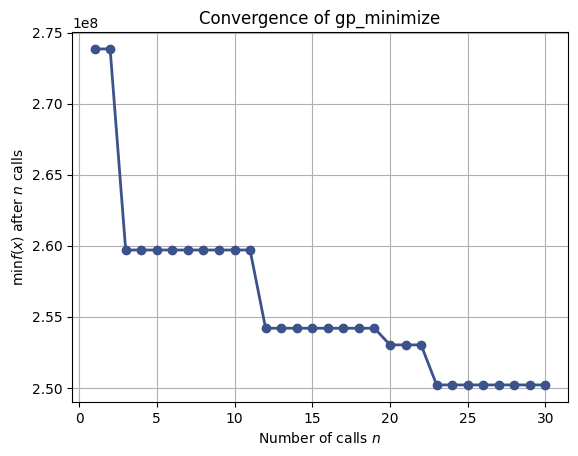

Validation MSE (gp_minimize): 37693031.84596612


[I 2025-03-25 21:25:09,231] A new study created in memory with name: no-name-6431bcc8-ba0b-46ca-8c57-870fd1bbf2a7


Validation MSE (BayesSearchCV): 49175769.670835935


[I 2025-03-25 21:25:09,565] Trial 0 finished with value: 254354017.24814454 and parameters: {'learning_rate': 0.07571112344746242, 'max_depth': 5, 'gamma': 0.09610786064749527, 'reg_alpha': 4.723063252644241, 'reg_lambda': 5.447828370419362, 'n_estimators': 116}. Best is trial 0 with value: 254354017.24814454.
[I 2025-03-25 21:25:10,363] Trial 1 finished with value: 258086711.54820126 and parameters: {'learning_rate': 0.07503907421634234, 'max_depth': 7, 'gamma': 0.8946576057924359, 'reg_alpha': 1.5628609093589731, 'reg_lambda': 3.179296180210493, 'n_estimators': 152}. Best is trial 0 with value: 254354017.24814454.
[I 2025-03-25 21:25:11,064] Trial 2 finished with value: 246632921.82560268 and parameters: {'learning_rate': 0.08433331979228584, 'max_depth': 6, 'gamma': 1.4935600671525138, 'reg_alpha': 1.5109746673990294, 'reg_lambda': 2.3243131610726016, 'n_estimators': 186}. Best is trial 2 with value: 246632921.82560268.
[I 2025-03-25 21:25:11,365] Trial 3 finished with value: 258443

Prediction MSE (Optuna): 45744973.697691984
Best method: gp_minimize
Best parameters: {'learning_rate': 0.20770050862089798, 'max_depth': 5, 'gamma': 0.0, 'alpha': 6.4, 'lambda': 6.4}
Train MSE: 42067.26300531296
Test MSE (Final Model): 37693031.84596612


In [217]:
bayes_xg_boost_10_model, bayes_xg_boost_10_params, train_prediction_bayes, test_prediction_bayes = bayes_xg_boost('close_10_ahead')


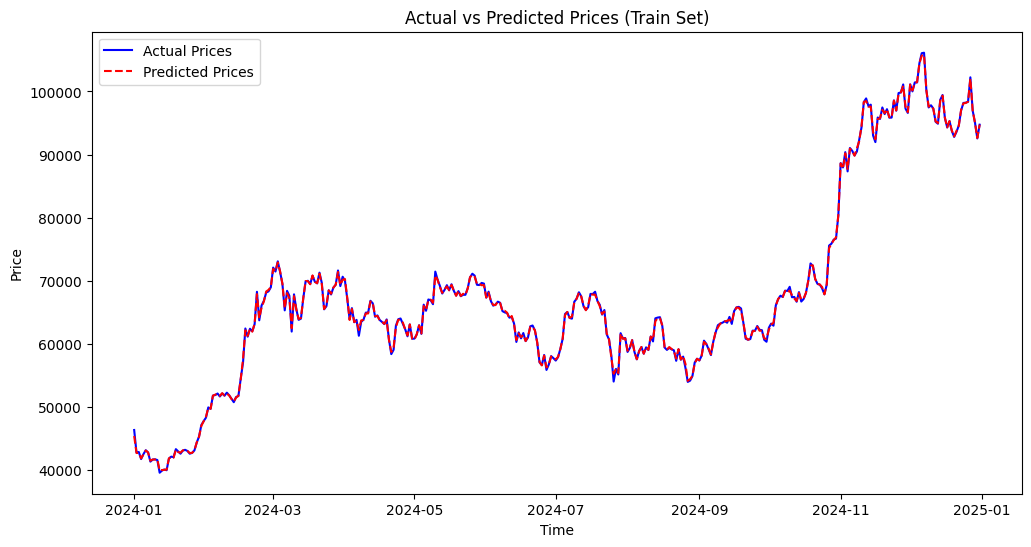

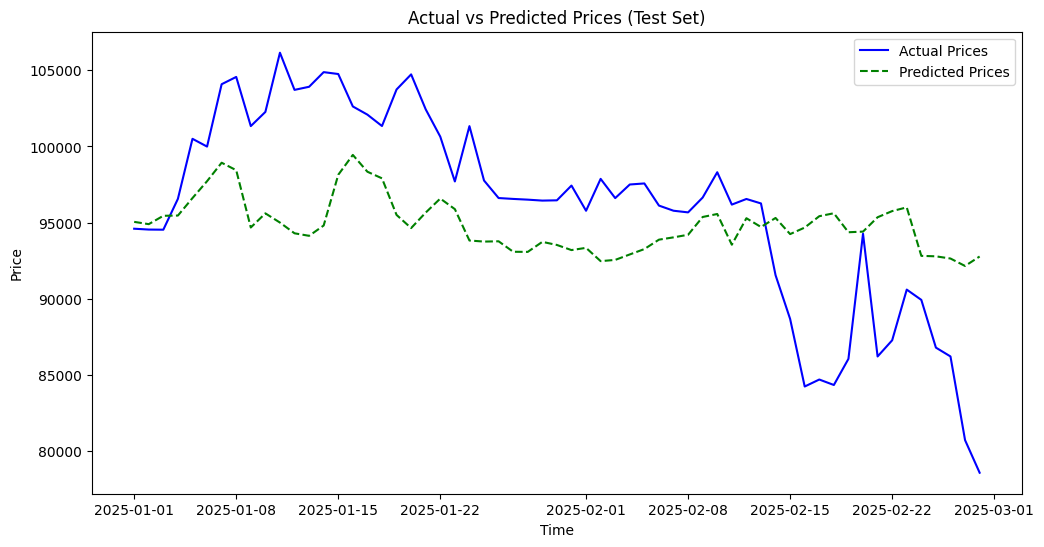

In [218]:
line_plot(train_prediction_bayes, test_prediction_bayes, 'close_10_ahead')

### Develop Trading Strategy

In [ ]:
# Predict future prices
def predictions(model, col_name):
    train_data[col_name] = model.preditc(train_data[features])
    test_data[col_name] = model.predict(test_data[features])




In [48]:
from skopt import gp_minimize

# Define the objective function for weight optimization
def objective(weights):
    # Combine predictions using the weights
    combined_pred = (weights[0] * train_data['Pred_1_day'] +
                     weights[1] * train_data['Pred_2_day'] +
                     weights[2] * train_data['Pred_5_day'] +
                     weights[3] * train_data['Pred_10_day'] +
                     weights[4] * train_data['Pred_20_day'] +
                     weights[5] * train_data['Pred_30_day'])
    
    # Calculate the Sharpe ratio (or any other metric)
    returns = combined_pred.pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std()
    return -sharpe_ratio  # Minimize the negative Sharpe ratio

# Define the search space for weights
weight_space = [(0, 1) for _ in range(6)]

# Bayesian Optimization for weight optimization
res = gp_minimize(objective, weight_space, n_calls=50, random_state=42)
best_weights = res.x

KeyError: 'Pred_2_day'

## ARIMA

Preprocess Data

In [ ]:
# Create a new DataFrame with a clone of btc_data including the timestamp column
arima_df = btc_data.copy()
def calculate_weighted_averages(data, lags):
    for i in range(1, lags+1):
        
arima_df = btc_data[['close', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'OBV', 'MFI', 'ATR', 'upper_band', 'middle_band', 'lower_band', 'BBW', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'weighted_avg']].copy()
arima_df.reset_index(inplace=True)
print(arima_df.head())

   timestamp     close       SMA       EMA        RSI      MACD  MACD_signal  \
0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483  1008.875495   

    MACD_hist       OBV        MFI  ...    upper_band  middle_band  \
0 -145.010934  0.777210  80.743988  ...  74118.585226   66980.6605   
1 -145.010934  1.141570  80.743988  ...  74118.585226   66980.6605   
2 -145.010934  1.387102  80.743988  ...  74118.585226   66980.6605   
3 -145.010934  1.730745  80.743988  ...  74118.585226   66980.6605   
4 -145.010934  1.822706  80.743988  ...  74118.585226   66980.6605   

     lower_band       BBW     lag_1     lag_2     lag_3     lag_4     lag_5  \
0  59842.735774  0.

In [22]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Assuming 'data' is your DataFrame and 'date' is your timestamp column
arima_df['timestamp'] = pd.to_datetime(arima_df['timestamp'])  # Ensure date column is datetime
arima_df.set_index('timestamp', inplace=True)

# Check for missing values and fill them if needed
arima_df = arima_df.fillna(method='ffill') # Forward fill missing values

# Perform Augmented Dickey-Fuller test for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")

# Check stationarity on 'close' price
adf_test(arima_df['close'])


ADF Statistic: -1.3102930665164187
p-value: 0.6244501652162752
The series is non-stationary.


C:\Users\ryant\AppData\Local\Temp\ipykernel_27940\3696961266.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arima_df = arima_df.fillna(method='ffill') # Forward fill missing values


Difference the df to make it stationary

In [23]:
# First-order differencing to make the series stationary
arima_df['close_diff'] = arima_df['close'] - arima_df['close'].shift(1)

# Perform the ADF test again on the differenced series
adf_test(arima_df['close_diff'].dropna())

ADF Statistic: -20.611240059895128
p-value: 0.0
The series is stationary.


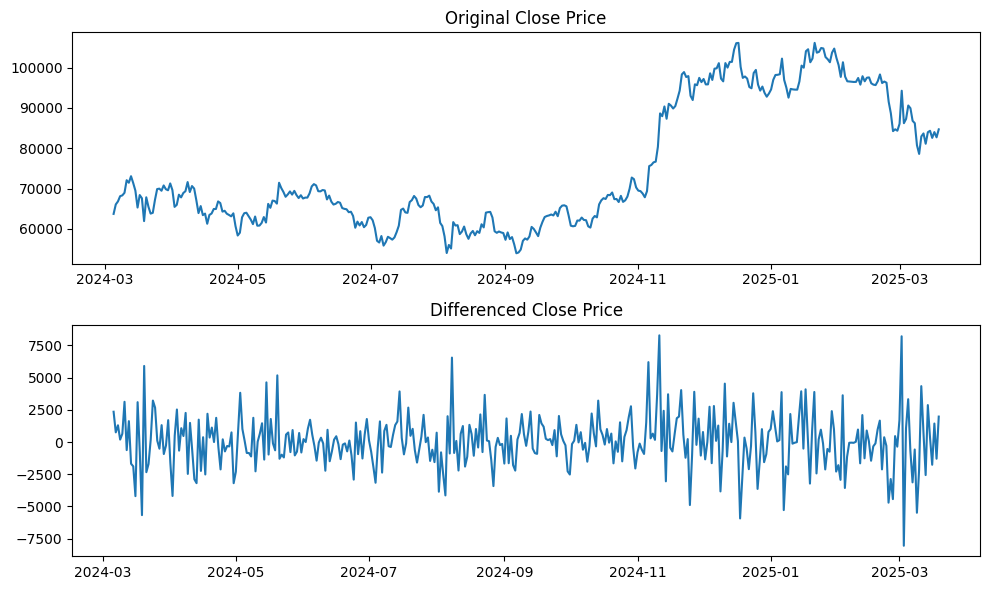

In [24]:
# Plot original data and differenced data
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(arima_df['close'])
plt.title('Original Close Price')

plt.subplot(2, 1, 2)
plt.plot(arima_df['close_diff'])
plt.title('Differenced Close Price')
plt.tight_layout()
plt.show()


In [ ]:
arima_df.reset_index(inplace=True)
# drop index column

print(arima_df.head())

   index  timestamp     close       SMA       EMA        RSI      MACD  \
0      0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483   
1      1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483   
2      2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483   
3      3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483   
4      4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483   

   MACD_signal   MACD_hist       OBV  ...  middle_band    lower_band  \
0  1008.875495 -145.010934  0.777210  ...   66980.6605  59842.735774   
1  1008.875495 -145.010934  1.141570  ...   66980.6605  59842.735774   
2  1008.875495 -145.010934  1.387102  ...   66980.6605  59842.735774   
3  1008.875495 -145.010934  1.730745  ...   66980.6605  59842.735774   
4  1008.875495 -145.010934  1.822706  ...   66980.6605  59842.735774   

        BBW     lag_1     lag_2     lag_3     lag_4     lag_5  weighted_avg  \
0  0.213134  68245.71  63113.97  61987.28  

In [27]:
arima_df.drop(columns=['index'], inplace=True)
print(arima_df.head())

   timestamp     close       SMA       EMA        RSI      MACD  MACD_signal  \
0 2024-03-05  63724.01 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
1 2024-03-06  66074.04 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
2 2024-03-07  66823.17 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
3 2024-03-08  68124.19 -0.513488 -0.456481  77.822116  0.078483  1008.875495   
4 2024-03-09  68313.27 -0.513488 -0.456481  77.822116  0.078483  1008.875495   

    MACD_hist       OBV        MFI  ...  middle_band    lower_band       BBW  \
0 -145.010934  0.777210  80.743988  ...   66980.6605  59842.735774  0.213134   
1 -145.010934  1.141570  80.743988  ...   66980.6605  59842.735774  0.213134   
2 -145.010934  1.387102  80.743988  ...   66980.6605  59842.735774  0.213134   
3 -145.010934  1.730745  80.743988  ...   66980.6605  59842.735774  0.213134   
4 -145.010934  1.822706  80.743988  ...   66980.6605  59842.735774  0.213134   

      lag_1     lag_2     lag_3     la

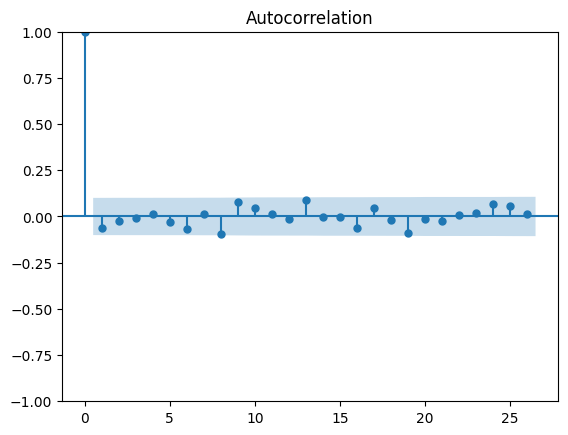

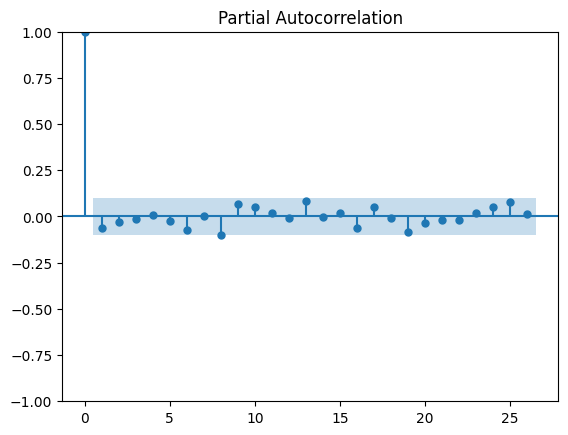

In [28]:
# Plot ACF and PACF for determining p and q
plot_acf(arima_df['close_diff'].dropna())  # ACF plot
plot_pacf(arima_df['close_diff'].dropna())  # PACF plot
plt.show()


In [29]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Fit ARIMA model (p=1, d=1, q=1)
model = ARIMA(arima_df['close'], order=(1, 1, 1))  # (p, d, q)
fitted_model = model.fit()

# Print model summary
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  380
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3426.834
Date:                Thu, 20 Mar 2025   AIC                           6859.668
Time:                        00:31:07   BIC                           6871.480
Sample:                             0   HQIC                          6864.356
                                - 380                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7085      1.311      0.540      0.589      -1.861       3.278
ma.L1         -0.7008      1.320     -0.531      0.595      -3.288       1.886
sigma2      4.184e+06   2.15e+05     19.474      0.0

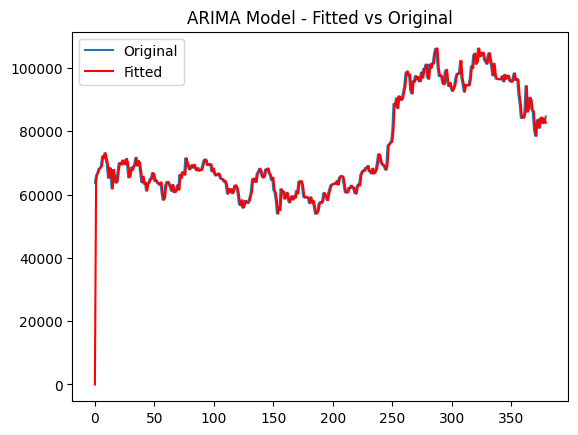

In [30]:
# Plot the forecasted values along with the original series
plt.plot(arima_df['close'], label='Original')
plt.plot(fitted_model.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.title("ARIMA Model - Fitted vs Original")
plt.show()


In [31]:
# Forecast the next 10 periods (e.g., days)
forecast = fitted_model.forecast(steps=10)

# Print the forecasted values
print(forecast)


380    84700.285519
381    84708.217584
382    84713.837480
383    84717.819195
384    84720.640255
385    84722.638985
386    84724.055093
387    84725.058410
388    84725.769264
389    84726.272906
Name: predicted_mean, dtype: float64


### Evaluation

In [ ]:
# Buy & Hold strategy
test_data['Buy_Hold_Returns'] = test_data['Close'].pct_change()
test_data['Cumulative_Buy_Hold_Returns'] = (1 + test_data['Buy_Hold_Returns']).cumprod()

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['Cumulative_Strategy_Returns'], label='Trading Strategy')
plt.plot(test_data['Cumulative_Buy_Hold_Returns'], label='Buy & Hold')
plt.legend()
plt.show()